First we will begin by downloading the required libraries and download the kaggle dataset

In [2]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("benroshan/factors-affecting-campus-placement")

100%|██████████| 4.51k/4.51k [00:00<00:00, 3.25MB/s]

Extracting files...


DATA EXPLORATION

Step 1: Read the data into the df and inspect

In [3]:
# this will actually open the dataframe in the enviroment 
csv_file = os.path.join(path, "Placement_Data_Full_Class.csv")  
df = pd.read_csv(csv_file)

Step 2: Begin some cleaning process so we can inspect a bit more

In [4]:

# this is the data cleaning step for the data visiluization, we will use one hot encoding for the ML model 
# The following functions are used for these conversions: 
def hsc_s_converter(x): 
    dic = {
        'Commerce': 0, 
        'Science': 1, 
        'Arts': 2
    }
    return dic[x]

def hsc_b_converter(x): 
    dic = {
        'Central': 0, 
        'Others': 1, 
    }
    return dic[x]

def degree_t_converter(x): 
    degree_dict = dict(enumerate(df.degree_t.unique()))
    inverted_degree_dict = {v: k for k, v in degree_dict.items()}
    inverted_degree_dict[x]

def specialisation_converter(x): 
    degree_dict = dict(enumerate(df.specialisation.unique()))
    inverted_degree_dict = {v: k for k, v in degree_dict.items()}
    inverted_degree_dict[x]

# Here we will apply the encodings 
df['gender_int'] = df['gender'].apply(lambda x: 1 if x=='M' else 0)  # M: 1 , F:0
df['status_int'] = df['status'].apply(lambda x: 1 if x=='Placed' else 0)  # Placed: 1 , NOT Placed:0
df['hsc_s_int'] = df.hsc_s.apply(lambda x: hsc_s_converter(x))
df['hsc_b_int'] = df.hsc_b.apply(lambda x: hsc_b_converter(x))
df['degree_t_int'] = df.degree_t.apply(lambda x: degree_t_converter(x))
df['workex_int'] = df.workex.apply(lambda x: 1 if x=='Yes' else 0)
df['specialisation_int'] = df.specialisation.apply(lambda x: specialisation_converter(x))


In [5]:
df.rename(columns={
    'sl_no': 'Serial_Number',
    'gender': 'Gender',
    'ssc_p': 'Secondary_School_Percentage',
    'ssc_b': 'Secondary_School_Board',
    'hsc_p': 'Higher_Secondary_Percentage',
    'hsc_b': 'Higher_Secondary_Board',
    'hsc_s': 'Higher_Secondary_Stream',
    'degree_p': 'Degree_Percentage',
    'degree_t': 'Degree_Type',
    'workex': 'Work_Experience',
    'etest_p': 'Employability_Test_Percentage',
    'specialisation': 'MBA_Specialisation',
    'mba_p': 'MBA_Percentage',
    'status': 'Placement_Status',
    'salary': 'Salary',
    # Encoded columns:
    'gender_int': 'Gender_Code',
    'status_int': 'Placement_Code',
    'hsc_s_int': 'Higher_Secondary_Stream_Code',
    'hsc_b_int': 'Higher_Secondary_Board_Code',
    'degree_t_int': 'Degree_Type_Code',
    'workex_int': 'Work_Experience_Code',
    'specialisation_int': 'MBA_Specialisation_Code'
}, inplace=True)


<Axes: >

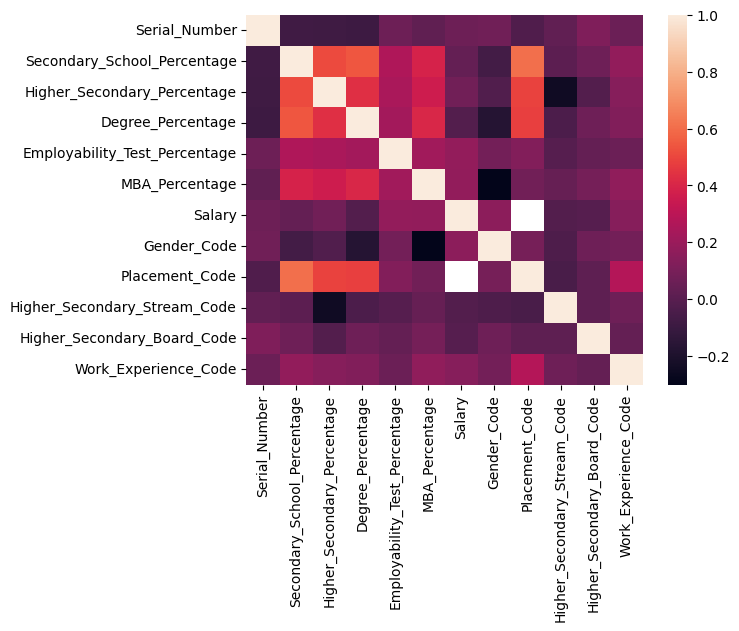

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(df.corr(numeric_only=True))

Text(0.5, 1.0, 'Students who do better in Higher also do better in Lower school, these students also get jobs')

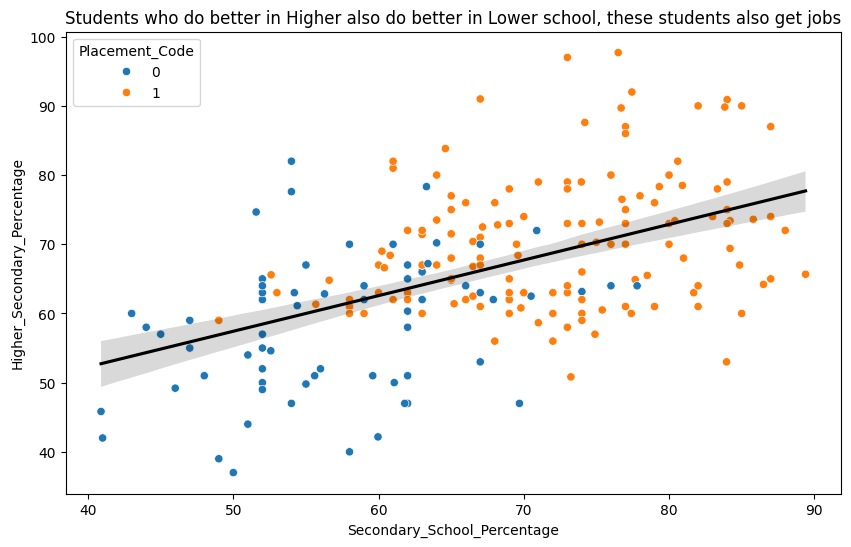

In [9]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Secondary_School_Percentage', y='Higher_Secondary_Percentage', hue='Placement_Code', data=df)
sns.regplot(x='Secondary_School_Percentage', y='Higher_Secondary_Percentage', color='black', scatter=False, data=df)

plt.xlabel("Secondary_School_Percentage")
plt.ylabel("Higher_Secondary_Percentage")
plt.title("Students who do better in Higher also do better in Lower school, these students also get jobs")

/var/folders/zh/yytt3ddj22bgdn3b0rscgglr0000gn/T/ipykernel_41729/562587451.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfPlot['Combined_Degree'] = dfPlot[['Degree_Type','MBA_Specialisation']].apply(lambda x: f'{x[0]} & {x[1]}',axis=1)


Text(0, 0.5, 'AVG Salary')

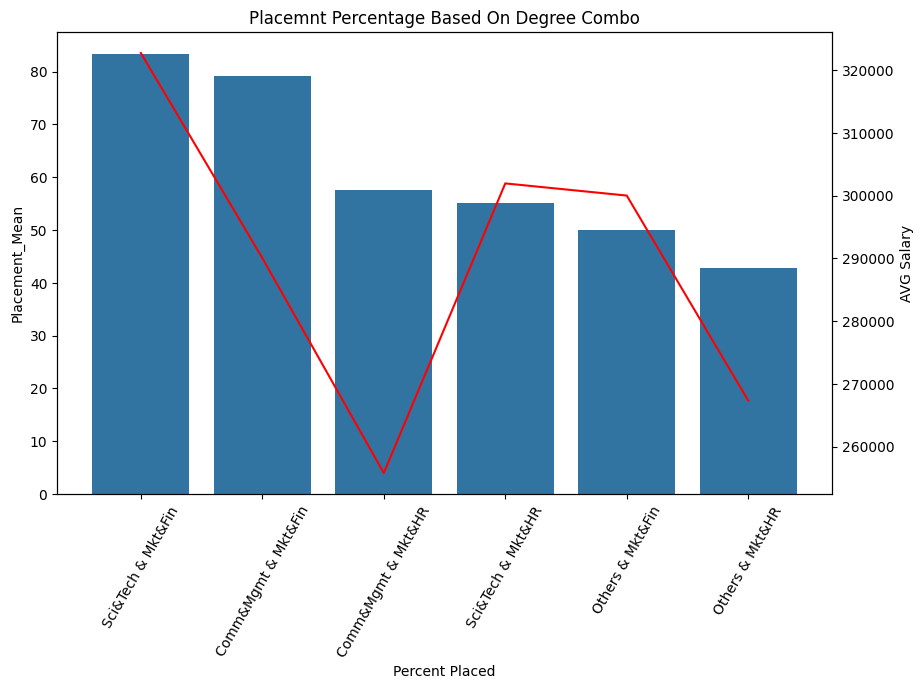

In [11]:
import scipy.stats as stats
import numpy as np

dfPlot = df.groupby(['MBA_Specialisation', 'Degree_Type']).agg(
    Placement_Mean=('Placement_Code', 'mean'),
    Placement_Count=('Placement_Code', 'count'),
    Salary_Mean=('Salary', 'mean')
    ).reset_index()

dfPlot = dfPlot.sort_values(by=['Placement_Mean'], ascending=False).reset_index(drop=True)
dfPlot['Placement_Mean'] = dfPlot['Placement_Mean'].apply(lambda x: x*100)
dfPlot['Combined_Degree'] = dfPlot[['Degree_Type','MBA_Specialisation']].apply(lambda x: f'{x[0]} & {x[1]}',axis=1)
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(data=dfPlot, x='Combined_Degree', y='Placement_Mean', ax=ax1)
plt.xlabel('Percent Placed')
plt.title("Placemnt Percentage Based On Degree Combo")
plt.xticks(rotation=60)  # Makes labels vertical

ax2 = ax1.twinx()

ax2.plot(dfPlot.Salary_Mean, label='Avg Salary', color='red')
ax2.set_ylabel("AVG Salary")


# dfPlot

/var/folders/zh/yytt3ddj22bgdn3b0rscgglr0000gn/T/ipykernel_41729/588491297.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfPlot['Placemnt_To_Sal'] = dfPlot[['Placement_Mean','Salary_Mean']].apply(lambda x: (x[0]*x[1])/100000,axis=1)


Text(0.5, 1.0, 'Combined Degree To Expected Salary')

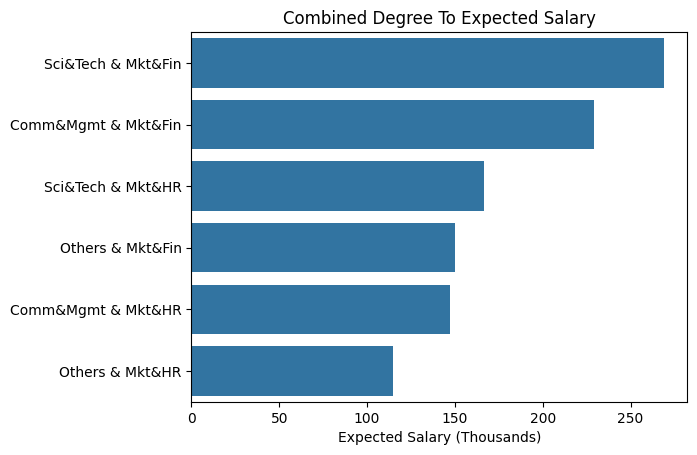

In [12]:
dfPlot['Placemnt_To_Sal'] = dfPlot[['Placement_Mean','Salary_Mean']].apply(lambda x: (x[0]*x[1])/100000,axis=1)

dfPlot = dfPlot.sort_values(by='Placemnt_To_Sal', ascending=False)
sns.barplot(data=dfPlot, y=dfPlot.Combined_Degree, x=dfPlot.Placemnt_To_Sal)
plt.xlabel("Expected Salary (Thousands)")
plt.ylabel("")

plt.title("Combined Degree To Expected Salary")



MODEL BUILDING

In [13]:
# Here we pick the features we want to use in our ML model 
df_ml = df[['Gender', 'Secondary_School_Percentage',
       'Higher_Secondary_Percentage',
       'Higher_Secondary_Stream',
       'Degree_Percentage', 'Degree_Type', 'Work_Experience',
       'Employability_Test_Percentage', 'MBA_Specialisation', 'MBA_Percentage',
       'Placement_Status', 'Salary']]

# Inspect again which columns will require one hot encoding 
# df_ml.info()

# Specify those columns columns in a list which is then used to create the one hot encoding 
categorical_cols = ['Gender', 'Higher_Secondary_Stream', 'Degree_Type', 'Work_Experience', 'MBA_Specialisation']
df_ml['Placement_Status']=  df_ml['Placement_Status'].apply(lambda x: 0 if x == 'Not Placed' else 1)

# Here we create the one hot encoding and confirm that it worked (looks like it did)
df_ml = pd.get_dummies(df_ml, columns=categorical_cols)
df_ml.dtypes


/var/folders/zh/yytt3ddj22bgdn3b0rscgglr0000gn/T/ipykernel_41729/3789986536.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml['Placement_Status']=  df_ml['Placement_Status'].apply(lambda x: 0 if x == 'Not Placed' else 1)


Secondary_School_Percentage         float64
Higher_Secondary_Percentage         float64
Degree_Percentage                   float64
Employability_Test_Percentage       float64
MBA_Percentage                      float64
Placement_Status                      int64
Salary                              float64
Gender_F                               bool
Gender_M                               bool
Higher_Secondary_Stream_Arts           bool
Higher_Secondary_Stream_Commerce       bool
Higher_Secondary_Stream_Science        bool
Degree_Type_Comm&Mgmt                  bool
Degree_Type_Others                     bool
Degree_Type_Sci&Tech                   bool
Work_Experience_No                     bool
Work_Experience_Yes                    bool
MBA_Specialisation_Mkt&Fin             bool
MBA_Specialisation_Mkt&HR              bool
dtype: object

In [14]:
# Here we check for some potential Null values, this is important that we do 
# this here as our data set is relativly small and we want to keep as much data 
# as possible 
df_ml[['Placement_Status', 'Salary']].isna().sum()


Placement_Status     0
Salary              67
dtype: int64

In [15]:
# we theorize that the null values are due to unemployment and will check here to confirm that this is truely the case. 
df_ml[df_ml['Placement_Status'] == 0]['Salary']

print('\n\nNumber of failed placement values: ', df_ml[df_ml['Placement_Status'] == 0]['Salary'].shape, 
      '\nNull Value Count',df_ml[(df_ml['Placement_Status'] == 0) & (df_ml['Salary'].isna())]['Salary'].shape)




Number of failed placement values:  (67,) 
Null Value Count (67,)


In [16]:
# it looks like this is the case, and will set salary to 0 for unemployed individuals to avoid null values 
df_ml.loc[df_ml['Placement_Status'] == 0, 'Salary'] = 0

# check that this worked
df_ml[df_ml['Placement_Status'] == 0]['Salary']


3      0.0
5      0.0
6      0.0
9      0.0
12     0.0
      ... 
198    0.0
201    0.0
206    0.0
208    0.0
214    0.0
Name: Salary, Length: 67, dtype: float64

In [17]:
# We are not splitting the data in to two sets for each model to ensure that we can stay as custimizable as possible 
df_ml_PS = df_ml.drop(columns=["Salary", "Employability_Test_Percentage"])

# For our salary, we will drop all of NA values since we do want any NA values in our validation set
df_ml_salary = df_ml.drop(columns=["Employability_Test_Percentage"])
df_ml_salary = df_ml


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

boolean_features = ['Gender_F','Gender_M','Degree_Type_Comm&Mgmt','Degree_Type_Others','Degree_Type_Sci&Tech','Work_Experience_No','Work_Experience_Yes','MBA_Specialisation_Mkt&Fin','MBA_Specialisation_Mkt&HR']
num_features = ['Secondary_School_Percentage', 'Higher_Secondary_Percentage',
       'Degree_Percentage', 'Employability_Test_Percentage', 'MBA_Percentage',
       'Placement_Status']
scaler = MinMaxScaler()
# Split and scale our data our data into training and testing

features = num_features + boolean_features

X = df_ml_salary[features]
y = df_ml_salary['Salary']

X_train_salary, X_test_salary, y_train_salary, y_test_salary = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_salary[num_features] = scaler.fit_transform(X_train_salary[num_features])
X_test_salary[num_features]  = scaler.transform(X_test_salary[num_features])




1. LINEAR REGRESSION MODEL FOR SALARY 

In [21]:
from sklearn.linear_model import LinearRegression
lr_model_salary = LinearRegression().fit(X_train_salary, y_train_salary) 

In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

lr_model_predict_salary = lr_model_salary.predict(X_test_salary)
lr_model_predict_score = r2_score(y_test_salary, lr_model_predict_salary)

mse = mean_squared_error(y_test_salary, lr_model_predict_salary)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_salary, lr_model_predict_salary)
mdae = median_absolute_error(y_test_salary, lr_model_predict_salary)
r2 = r2_score(y_test_salary, lr_model_predict_salary)
print(f"""
MSE: {mse}
RMSE: {rmse}
MAE: {mae}
MDAE: {mdae}
R2: {r2}
""")



MSE: 5847283813.24705
RMSE: 76467.53437405347
MAE: 44068.80358650467
MDAE: 26906.21893858754
R2: 0.7348622057366053



Our outcome here is very poor and have huge amounts of error, we will try to remove some potentially noisy features

In [24]:
# We will now inspect the correlation and see which values may be best for prediction of salary 
sal_cor = df.corr(numeric_only=True).sort_values(by='Salary')['Salary']
print(sal_cor.index)
print(sal_cor)

Index(['Degree_Percentage', 'Higher_Secondary_Stream_Code',
       'Higher_Secondary_Board_Code', 'Secondary_School_Percentage',
       'Serial_Number', 'Higher_Secondary_Percentage', 'Work_Experience_Code',
       'Gender_Code', 'MBA_Percentage', 'Employability_Test_Percentage',
       'Salary', 'Placement_Code'],
      dtype='object')
Degree_Percentage               -0.019272
Higher_Secondary_Stream_Code    -0.017923
Higher_Secondary_Board_Code     -0.007549
Secondary_School_Percentage      0.035330
Serial_Number                    0.063764
Higher_Secondary_Percentage      0.076819
Work_Experience_Code             0.136920
Gender_Code                      0.158912
MBA_Percentage                   0.175013
Employability_Test_Percentage    0.178307
Salary                           1.000000
Placement_Code                        NaN
Name: Salary, dtype: float64


In [25]:
# first create the smaller df with the columns we care about
df_ml_salary_shortend = pd.DataFrame(df[['Degree_Type','Higher_Secondary_Percentage', 'Work_Experience',
       'Gender', 'MBA_Percentage', 'Employability_Test_Percentage', 'MBA_Specialisation','Salary']])

# now we will have to one hot encode these once again 
categorical_cols = ['Gender','Degree_Type', 'Work_Experience', 'MBA_Specialisation']

# Here we create the one hot encoding once again with the new DF
df_ml_salary_shortend = pd.get_dummies(df_ml_salary_shortend, columns=categorical_cols)


In [26]:
# check that it worked
df_ml_salary_shortend = df_ml_salary_shortend.dropna()
df_ml_salary_shortend.info()
print(df_ml_salary_shortend.shape)


<class 'pandas.core.frame.DataFrame'>
Index: 148 entries, 0 to 213
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Higher_Secondary_Percentage    148 non-null    float64
 1   MBA_Percentage                 148 non-null    float64
 2   Employability_Test_Percentage  148 non-null    float64
 3   Salary                         148 non-null    float64
 4   Gender_F                       148 non-null    bool   
 5   Gender_M                       148 non-null    bool   
 6   Degree_Type_Comm&Mgmt          148 non-null    bool   
 7   Degree_Type_Others             148 non-null    bool   
 8   Degree_Type_Sci&Tech           148 non-null    bool   
 9   Work_Experience_No             148 non-null    bool   
 10  Work_Experience_Yes            148 non-null    bool   
 11  MBA_Specialisation_Mkt&Fin     148 non-null    bool   
 12  MBA_Specialisation_Mkt&HR      148 non-null    bool   


In [27]:

scaler = MinMaxScaler()
# Split and scale our data our data into training and testing

num_features = [
    'Higher_Secondary_Percentage',
    'MBA_Percentage',
    'Employability_Test_Percentage'
]

boolean_features = [
    'Gender_F',
    'Gender_M',
    'Degree_Type_Comm&Mgmt',
    'Degree_Type_Others',
    'Degree_Type_Sci&Tech',
    'Work_Experience_No',
    'Work_Experience_Yes',
    'MBA_Specialisation_Mkt&Fin',
    'MBA_Specialisation_Mkt&HR'
]


features = num_features + boolean_features

X = df_ml_salary_shortend[features]
y = df_ml_salary_shortend['Salary']
X_train_salary, X_test_salary, y_train_salary, y_test_salary = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_salary[num_features] = scaler.fit_transform(X_train_salary[num_features])
X_test_salary[num_features]  = scaler.transform(X_test_salary[num_features])



In [28]:
from sklearn.linear_model import LinearRegression
lr_model_salary = LinearRegression().fit(X_train_salary, y_train_salary) 

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

lr_model_predict_salary = lr_model_salary.predict(X_test_salary)
lr_model_predict_score = r2_score(y_test_salary, lr_model_predict_salary)

mse = mean_squared_error(y_test_salary, lr_model_predict_salary)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_salary, lr_model_predict_salary)
mdae = median_absolute_error(y_test_salary, lr_model_predict_salary)
r2 = r2_score(y_test_salary, lr_model_predict_salary)
print(f"""
MSE: {mse}
RMSE: {rmse}
MAE: {mae}
MDAE: {mdae}
R2: {r2}
""")



MSE: 8485874710.188348
RMSE: 92118.80758123363
MAE: 60422.798755756005
MDAE: 44837.84477215452
R2: -0.0037249898500384404



In [30]:
# Old: 
# MSE: 9528801689.6
# RMSE: 97615.5811825141
# MAE: 65555.2
# MDAE: 42952.0
# R2: -0.12708432610885279


# New: 
# MSE: 8485874710.188348
# RMSE: 92118.80758123363
# MAE: 60422.798755756005
# MDAE: 44837.844772154494
# R2: -0.0037249898500384404

# we see here a bit of an improvemnt with our scores however not much. This does however make sense since we see little correlation
# between salary and the other attributes within our data set 

2. Logistic Regression for Outcome

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

boolean_features = ['Gender_F','Gender_M','Degree_Type_Comm&Mgmt','Degree_Type_Others','Degree_Type_Sci&Tech','Work_Experience_No','Work_Experience_Yes','MBA_Specialisation_Mkt&Fin','MBA_Specialisation_Mkt&HR']
num_features = ['Secondary_School_Percentage', 'Higher_Secondary_Percentage',
       'Degree_Percentage','MBA_Percentage']
scaler = MinMaxScaler()
# Split and scale our data our data into training and testing

features = num_features + boolean_features

X = df_ml_PS[features]
y = df_ml_PS['Placement_Status']

X_train_PS, X_test_PS, y_train_PS, y_test_PS = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_PS[num_features] = scaler.fit_transform(X_train_PS[num_features])
X_test_PS[num_features]  = scaler.transform(X_test_PS[num_features])




In [32]:

# scaler = MinMaxScaler()

# # Split and and scale the data 
# X_train_PS, X_test_PS, y_train_PS, y_test_PS = train_test_split(df_ml_PS.drop(columns=['Placement_Status']), df_ml_PS['Placement_Status'], test_size=0.2, random_state=42, stratify=df_ml['Placement_Status'])
# X_train_scaled_PS, X_test_scaled_PS = scaler.fit_transform(X_train_PS), scaler.transform(X_test_PS)  


In [33]:
from sklearn.linear_model import LogisticRegression

lgr_classifer = LogisticRegression(max_iter=1000, random_state=42)
lgr_classifer.fit(X_train_PS, y_train_PS)


LogisticRegression(max_iter=1000, random_state=42)

In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_pred_lgr = lgr_classifer.predict(X_test_PS)
print(classification_report(y_test_PS, y_pred_lgr))



              precision    recall  f1-score   support

           0       0.78      0.58      0.67        12
           1       0.85      0.94      0.89        31

    accuracy                           0.84        43
   macro avg       0.82      0.76      0.78        43
weighted avg       0.83      0.84      0.83        43



3. RandomForest Classifer for job outcome outcome 

In [35]:
from sklearn.ensemble import RandomForestClassifier
rdmf_classifer = RandomForestClassifier(n_estimators=100, random_state=42)
rdmf_classifer.fit(X_train_PS, y_train_PS)


RandomForestClassifier(random_state=42)

In [36]:
y_pred_dmf = rdmf_classifer.predict(X_test_PS)
print(classification_report(y_test_PS, y_pred_lgr))


              precision    recall  f1-score   support

           0       0.78      0.58      0.67        12
           1       0.85      0.94      0.89        31

    accuracy                           0.84        43
   macro avg       0.82      0.76      0.78        43
weighted avg       0.83      0.84      0.83        43



4. Neural Net Model (just for fun)

In [37]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(random_state=42, max_iter=1000).fit(X_train_PS, y_train_PS)

In [38]:
y_pred_mlp = mlp_clf.predict(X_test_PS)
print(classification_report(y_test_PS, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.91      0.94      0.92        31

    accuracy                           0.88        43
   macro avg       0.86      0.84      0.85        43
weighted avg       0.88      0.88      0.88        43



Trying out our model    

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Serial_Number                  215 non-null    int64  
 1   Gender                         215 non-null    object 
 2   Secondary_School_Percentage    215 non-null    float64
 3   Secondary_School_Board         215 non-null    object 
 4   Higher_Secondary_Percentage    215 non-null    float64
 5   Higher_Secondary_Board         215 non-null    object 
 6   Higher_Secondary_Stream        215 non-null    object 
 7   Degree_Percentage              215 non-null    float64
 8   Degree_Type                    215 non-null    object 
 9   Work_Experience                215 non-null    object 
 10  Employability_Test_Percentage  215 non-null    float64
 11  MBA_Specialisation             215 non-null    object 
 12  MBA_Percentage                 215 non-null    flo

Feature Importance for Random Forest

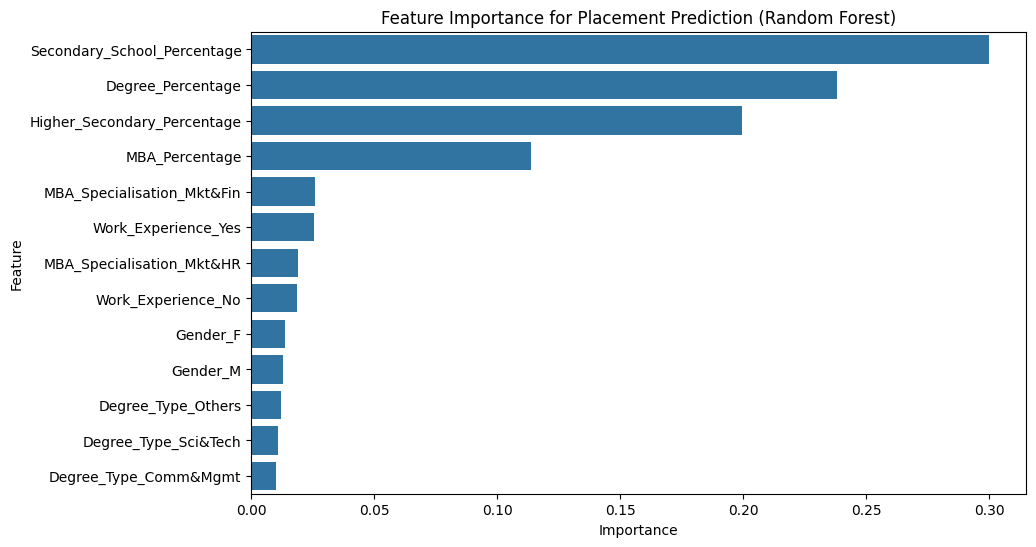

In [45]:
importances = rdmf_classifer.feature_importances_
feature_names = X_train_PS.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance for Placement Prediction (Random Forest)")
plt.show()

# This bar chart displays the relative importance of each feature used by the Random Forest classifier in predicting whether a student gets placed.
# A higher value indicates that the feature had more influence on the model's decision. This helps us interpret which factors
# are most predictive of placement success.

Confusion Matrix Heatmap

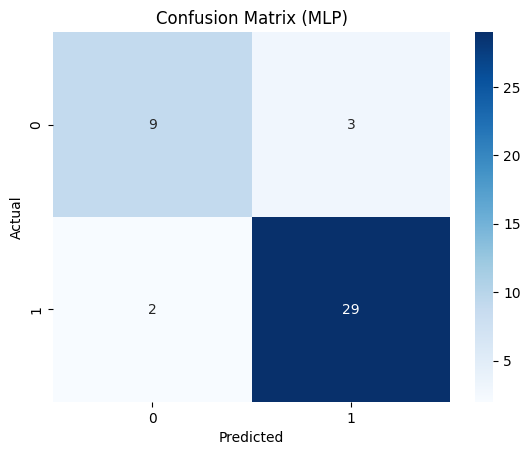

In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_PS, y_pred_mlp)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (MLP)")
plt.show()

# The confusion matrix visually compares the actual placement outcomes to the predicted ones made by the MLP classifier.
# It displays counts of true positives, true negatives, false positives, and false negatives.
# This is useful for diagnosing how well the classifier distinguishes between placed and not placed candidates and where it makes mistakes.

Distribution of Salary by Work Experience

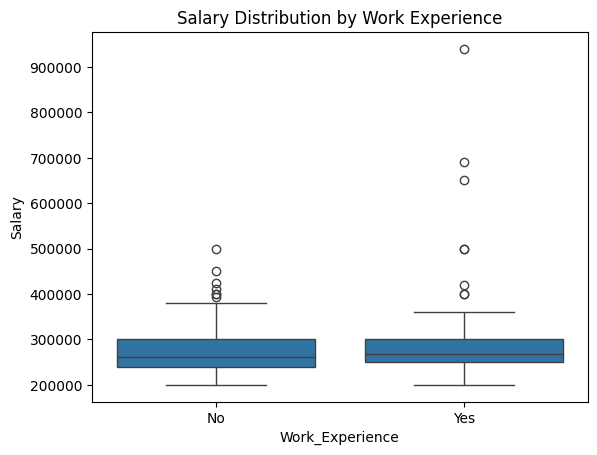

In [47]:
sns.boxplot(x='Work_Experience', y='Salary', data=df[df['Salary'] > 0])
plt.title("Salary Distribution by Work Experience")
plt.show()

# This boxplot compares the distribution of salaries between students with and without prior work experience.
# It highlights median salaries, interquartile ranges, and outliers, helping us understand how much work experience may impact earning potential after placement.

Pairplot of Key Features Colored by Placement

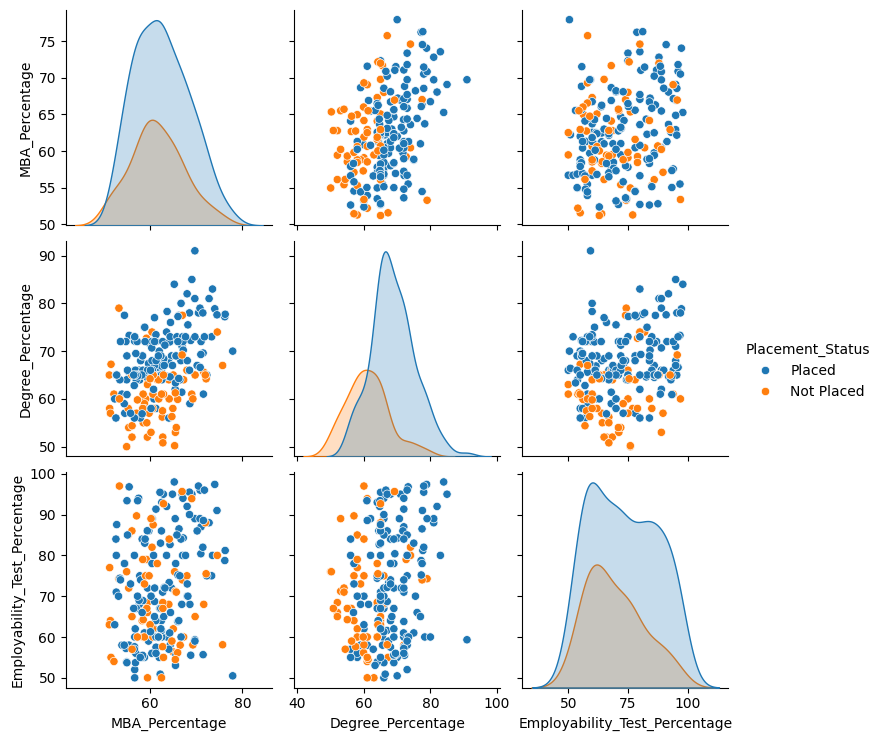

In [48]:
sns.pairplot(df, vars=['MBA_Percentage', 'Degree_Percentage', 'Employability_Test_Percentage'], hue='Placement_Status')

# This pairplot helps us visually explore how feature combinations correlate with placement success.